# Retrieve Documents by ID API
This API retrieves documents (patents or publications) by their unique IDs and returns their metadata and embeddings. Useful for fetching and analyzing specific documents.

In [77]:
from dotenv import dotenv_values
import pandas as pd
import requests

# Load environment variables from .env file
conf = dotenv_values()
API_KEY = conf["API_KEY"]

# Publication type and ids
data = [
    {"index": "publications", "id": "W2531700612"},
    {"index": "publications", "id": "10.1073/pnas.1208507109"},
    {"index": "patents", "id": "64440517"},
    {"index": "patents", "id": "US11394112B2"}
]

In [78]:
# API Settings
URL = 'https://api.logic-mill.net/api/v1/graphql/'
headers = {
    'content-type': 'application/json',
    'Authorization': 'Bearer ' + API_KEY,
}

# Build GraphQL query
query = """
query Documents($data: [DatabaseSearchDocument]) {
  Documents(data: $data) {id url PatspecterEmbedding}
}
"""

# Build variables
variables = {"data": data}

In [79]:
# Send a POST request to the API
response = requests.post(URL, headers=headers, json={'query': query , 'variables': variables})

In [80]:
# Handle response
if not response.ok:
    raise Exception(f"Error: {response.status_code} - {response.text}")

json_response = response.json()
encoded_documents = json_response['data']['Documents']
df = pd.json_normalize(encoded_documents)
df

,PatspecterEmbedding,id,url
0,"[0.61712974, 0.29766896, -0.8525641, 0.3674234...",W2531700612,https://openalex.org/works/W2531700612
1,"[-0.31607285, -0.023326293, -0.41022038, 1.004...",64440517,https://worldwide.espacenet.com/patent/search?...
2,"[0.69582003, -0.09935876, 3.0098226e-05, 0.413...",W2019670881,https://openalex.org/works/W2019670881
3,"[0.26689792, 0.51510215, -0.23139955, 0.209538...",69888419,https://worldwide.espacenet.com/patent/search?...


## Multiple Document Retrieval
The following example retrieves documents from three different subject fields and conducts clustering based on the retrieved embedding.

In [81]:
# List of Open Alex IDs
publications = ["W4205325213", "W2953522645", "W4200466434",    # Publication on AI
                "W4205230890", "W4205110436", "W2115072149",    # Publications on Medicine
                "W4389705108", "W4319971921", "W4384524750"]    # Publications on Psychology
# Build variables for query
variables = {"data": [
    {"index": "publications", "id": pub} for pub in publications
]}

In [82]:
# Send a POST request to the API
response = requests.post(URL, headers=headers, json={'query': query , 'variables': variables})

In [83]:
# Handle response
if not response.ok:
    raise Exception(f"Error: {response.status_code} - {response.text}")

json_response = response.json()
encoded_documents = json_response['data']['Documents']

### Clustering
We can use the retrieved embeddings to cluster documents. The documents are perfectly clustered into their subject area.

In [84]:
from sklearn.cluster import KMeans
import numpy as np

# Extract embeddings from documents
embeddings = [doc['PatspecterEmbedding'] for doc in encoded_documents]

# Convert to numpy array
X = np.array(embeddings)

# Cluster into 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, verbose=True)
labels = kmeans.fit_predict(X)

# Print cluster assignments
for doc, label in zip(encoded_documents, labels):
    print(f"ID: {doc['id']} - Cluster: {label}")

Initialization complete
Iteration 0, inertia 457.56619897863914.
Iteration 1, inertia 236.0513393689663.
Converged at iteration 1: strict convergence.
ID: W4205325213 - Cluster: 2
ID: W2953522645 - Cluster: 2
ID: W4200466434 - Cluster: 2
ID: W4205230890 - Cluster: 0
ID: W4205110436 - Cluster: 0
ID: W2115072149 - Cluster: 0
ID: W4389705108 - Cluster: 1
ID: W4319971921 - Cluster: 1
ID: W4384524750 - Cluster: 1


### Dimensionality Reduction and Visualization of Clusters

To better understand the clustering results, we can project the high-dimensional embeddings into two dimensions using PCA and plot them. Each point represents a document, colored by its cluster assignment. This visualization helps to intuitively assess how well the documents are separated into clusters.

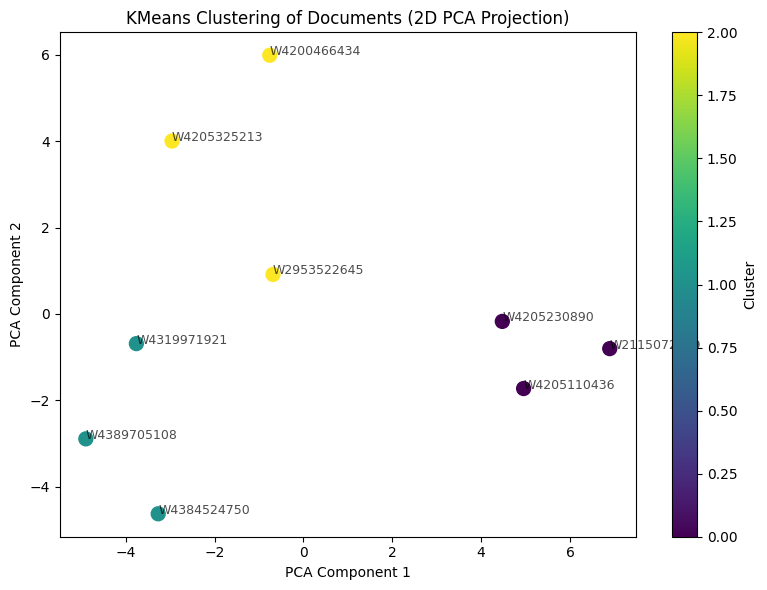

In [85]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce embeddings to 2D for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis', s=100)

# Annotate points with document IDs
for i, doc in enumerate(encoded_documents):
    plt.annotate(doc['id'], (X_2d[i, 0], X_2d[i, 1]), fontsize=9, alpha=0.7)

plt.title("KMeans Clustering of Documents (2D PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()